Note, all imports for this notebook are below:

In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, \
HashingVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_union, make_pipeline

import string

# Intro to Natural Language Processing 

Natural language processing is a fairly large field and one that we will not cover in nearly enough detail this week. For our purposes, it involves the processing of written language into numbers that we will then use during modeling. This puts it squarely in the preprocessing / feature engineering stage.

> Note, there are plenty of cases where we may want to predict what the next word of a statement will be or to automatically provide an answer to a question, program a chat bot, etc. These also fall under the NLP umbrella, but for this week's discussions, we'll focus on just going from language -> numbers

## A Simple Example

Suppose we are building a spam/ham classifier. Input are emails, output is a binary classification of whether or not the email is a spam message or not.

Here's an example of an input email:

> Hello, I saw your contact information on LinkedIn. I have carefully read through your profile and you seem to have an outstanding personality. This is one major reason why I am in contact with you. My name is Mr. Valery Grayfer Chairman of the Board of Directors of PJSC "LUKOIL". I am 86 years old and I was diagnosed with cancer 2 years ago. I will be going in for an operation later this week. I decided to WILL/Donate the sum of 8,750,000.00 Euros(Eight Million Seven Hundred And Fifty Thousand Euros Only etc. etc.

and a second example:

> Hello, I am writing in regards to your application to the position of Data Scientist at Hooli X. We are pleased to inform you that you passed the first round of interviews and we would like to invite you for an on-site interview with our Senior Data Scientist Mr. John Smith. You will find attached to this message further information on date, time and location of the interview. Please let me know if I can be of any further assistance. Best Regards.

We might want to look at certain words and determine where they happen:

### Check for Understanding 1 (10 Minutes)

With a partner, do the following:

1. Identify which email is a spam email and which is a ham email. 
2. What words exist in the spam email that do not exist in the ham email? What about the reverse?
3. Using these words, create a rule that would classify a spam email and do not share it with your partner.
> For example, the rule could be "If the email refers to cancer, it is a spam email"
4. Go online (or into your inbox!) and find a second example of a spam email. PM this text to your partner. Does their rule correctly classify this email?

```
Instructor answer:

This is more of an exploratory prompt than one that requires a specific answer.
```

## Bag of Words Approaches

The bag-of-words model is a simplifying representation used in natural language processing. In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. In other words, how many times does each word happen?

One way to do this easily is with the `Counter` module in the standard library.

In [2]:
spam = '''
Hello, I saw your contact information on LinkedIn. I have carefully read through your profile and you seem to have an outstanding personality. This is one major reason why I am in contact with you. My name is Mr. Valery Grayfer Chairman of the Board of Directors of PJSC "LUKOIL". I am 86 years old and I was diagnosed with cancer 2 years ago. I will be going in for an operation later this week. I decided to WILL/Donate the sum of 8,750,000.00 Euros(Eight Million Seven Hundred And Fifty Thousand Euros Only etc. etc.
'''

ham = '''
Hello, I am writing in regards to your application to the position of Data Scientist at Hooli X. We are pleased to inform you that you passed the first round of interviews and we would like to invite you for an on-site interview with our Senior Data Scientist Mr. John Smith. You will find attached to this message further information on date, time and location of the interview. Please let me know if I can be of any further assistance. Best Regards.
'''

print(Counter(spam.lower().split()))
print('\n')
print(Counter(ham.lower().split()))

Counter({'i': 7, 'of': 4, 'and': 3, 'your': 2, 'contact': 2, 'have': 2, 'to': 2, 'an': 2, 'this': 2, 'is': 2, 'am': 2, 'in': 2, 'with': 2, 'the': 2, 'years': 2, 'etc.': 2, 'hello,': 1, 'saw': 1, 'information': 1, 'on': 1, 'linkedin.': 1, 'carefully': 1, 'read': 1, 'through': 1, 'profile': 1, 'you': 1, 'seem': 1, 'outstanding': 1, 'personality.': 1, 'one': 1, 'major': 1, 'reason': 1, 'why': 1, 'you.': 1, 'my': 1, 'name': 1, 'mr.': 1, 'valery': 1, 'grayfer': 1, 'chairman': 1, 'board': 1, 'directors': 1, 'pjsc': 1, '"lukoil".': 1, '86': 1, 'old': 1, 'was': 1, 'diagnosed': 1, 'cancer': 1, '2': 1, 'ago.': 1, 'will': 1, 'be': 1, 'going': 1, 'for': 1, 'operation': 1, 'later': 1, 'week.': 1, 'decided': 1, 'will/donate': 1, 'sum': 1, '8,750,000.00': 1, 'euros(eight': 1, 'million': 1, 'seven': 1, 'hundred': 1, 'fifty': 1, 'thousand': 1, 'euros': 1, 'only': 1})


Counter({'to': 5, 'of': 4, 'you': 4, 'the': 3, 'i': 2, 'data': 2, 'scientist': 2, 'we': 2, 'and': 2, 'further': 2, 'hello,': 1, 'am': 1

In this case, outside of prepositions and articles, most words are unique across these documents. However, for the ham email, the following interesting words happen more than once:

- data
- scientist
- further

and in the spam email:

- contact
- years
- etc

### Scikit-learn Options

Scikit-learn offers two different options for Bag-of-Words approaches to NLP:

- [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
- [`HashingVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html)

In **most** cases, you'll be using the `CountVectorizer` object, but there may be times, especially if you are on an older machine, that `HashingVectorizer` will be a huge timesaver.

> **Major Note**: NLP can take a lot of computing power. Don't be afraid to look for alternatives like `HashingVectorizer`, to cut your dataset down, to use fewer words, use a larger virtualized machine (such as on AWS). Working smart, not hard applies very well here!

[`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) will take a set of words and split them up into one column per word, with (by default) the count of the word for that row in that column. We'll walk through a brief example now and then dive into the options. 

This library is very full-featured and has a number of options to set or tweak -- get used to reviewing those options to make sure that you are gaining the most out of your work!

In [3]:
df = pd.DataFrame().from_dict({0: spam, 1: ham}, 
                             orient='index')
df.columns = ['text']
df

,text
0,"\nHello, I saw your contact information on Lin..."
1,"\nHello, I am writing in regards to your appli..."


In [4]:
cv = CountVectorizer()
cv.fit(df['text'])
cv.transform(df['text'])

<2x111 sparse matrix of type '<class 'numpy.int64'>'
	with 129 stored elements in Compressed Sparse Row format>

What is sparse matrix? Transformations like this tend to create matrices with a very large amount of zeroes (words may only show up once or twice across a number of documents, so a lot of extra memory is expended to represent a very large number of zeroes).

Sparse matrices collapse regular (dense) matrices by marking down only cases where a non-zero value is found for a certain combination of row and column. It then drops all the zeroes, allowing for a reduced memory footprint.

We can call `.todense()` on the output to convert it into a dense matrix. 

In [5]:
cv.transform(df['text']).todense()

matrix([[1, 1, 1, 1, 1, 2, 2, 3, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 2,
         0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0, 1, 0, 2,
         0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 4,
         1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
         1, 0, 0, 1, 0, 2, 2, 1, 1, 0, 2, 1, 1, 0, 1, 1, 2, 2, 0, 0, 2, 2, 2],
        [0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
         2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 1,
         1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 4,
         0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 1, 0, 2, 0, 1,
         0, 1, 1, 0, 1, 3, 1, 0, 0, 1, 5, 0, 0, 2, 0, 0, 1, 1, 1, 1, 0, 4, 1]])

In addition, we can grab the feature names and apply them if we are interested in seeing the distribution of words:

In [6]:
pd.DataFrame(cv.transform(df['text']).todense(), 
             columns=cv.get_feature_names()) # use .get_feature_names()

,00,000,750,86,ago,am,an,and,any,application,...,we,week,why,will,with,would,writing,years,you,your
0,1,1,1,1,1,2,2,3,0,0,...,0,1,1,2,2,0,0,2,2,2
1,0,0,0,0,0,1,1,2,1,1,...,2,0,0,1,1,1,1,0,4,1


Why the random numbers at the front? That comes from the `8,750,000.00` and `86` sections of the spam email -- our parser does not interpret `8,750,000.00` as one number but rather the string of words `[8, 750, 000, 00]`. 

### `CountVectorizer` Options

`CountVectorizer` takes the following (useful) keyword arguments:

| Argument | Default Value | Definition |
| :--- | :--- | :--- |
| `decode_error` | `strict` | What to do if text cannot be decoded. `strict` will raise a `UnicodeDecodeError`, `ignore` will skip that word, `replace` will attempt to replace it with a non-Unicode variant|
| `strip_accents` | `None` | When preprocessing a word, `CountVectorizer` does nothing with the accented characters. `ascii` will convert those characters if they have a direct ASCII mapping (à -> a, for example), and `unicode` is slower but will do it for all characters | 
| `preprocessor / tokenizer` | `None` | Ways to override how to split text into words (`tokenizer`) and what to do with those words before vectorizing (`preprocessor`) -- we'll discuss shortly |
| `ngram_range` | `(1, 1)` | Sometimes we may want each sequence of _n_ words as well as each individual word. This is known as an _ngram_ and we cna set that here | 
| `stop_words` | `None` | Whether or not to remove stop words. Will discuss later. |
| `max_df` | `1.0` | `df` refers to the document frequency -- how often does a given word show up across documents. If we set this to a float less than 1.0, any word that happens more frequently than that value will be discarded. Any integer will be the number of documents instead of the proportion | 
| `min_df` | `1` | Same as `max_df`, but for the number / proportion of documents that a word has to appear in before it is included |
| `max_features` | `None` | The top _n_ occuring features to include. If `None`, include all features. This is a great way to coerce `CountVectorizer` to return a matrix of a specific shape / size |
| `binary` | `False` | If `True`, return dummy variables instead of a count of occurances |

Whew! That's a lot!


### Check for Understanding 2 (15 Minutes)

For this Check for Understanding (and many others), we'll be using the [`20 Newsgroups`](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) dataset. This dataset includes a number of old messages from a set of newsgroups and is a standard dataset to practice NLP techniques with. 

For this first section, we will be using the first 100 messages from the `sci.space` newsgroup. We'll also be stripping them of any headers, footers, or quoted messages. 

In [7]:
space = fetch_20newsgroups(subset='train',
                          categories=['sci.space'],
                          remove=('headers', 'footers', 'quotes'))
space_messages = space['data'][:100]

In [8]:
print(space_messages[0], '\n', space_messages[-1])


Any lunar satellite needs fuel to do regular orbit corrections, and when
its fuel runs out it will crash within months.  The orbits of the Apollo
motherships changed noticeably during lunar missions lasting only a few
days.  It is *possible* that there are stable orbits here and there --
the Moon's gravitational field is poorly mapped -- but we know of none.

Perturbations from Sun and Earth are relatively minor issues at low
altitudes.  The big problem is that the Moon's own gravitational field
is quite lumpy due to the irregular distribution of mass within the Moon. 
 


If you want to have some fun.

Plug the basic formulas  into Lotus.

Use the spreadsheet auto re-calc,  and graphing functions
to produce  bar graphs  based on latitude,  tilt  and hours of day light avg.



`space_messages` now contains 100 space-themed messages that we will do some feature extraction on:

Individually, please try the following:

1. Use `CountVectorizer` (at its default settings) and Pandas to create a DataFrame where each column is a word in the text. 
    1. How large is your DataFrame? 
    2. What are the top 10 occuring words?
2. Reinstantiate `CountVectorizer` and set `ngram_range` to `(1, 2)`, then fit and transform the space messages into a DataFrame
    1. What does this do?
    2. How large is your DataFrame?
    3. What are the top 10 occuring words?
3. Reinstatiate `CountVectorizer` and set `min_df` to `0.10` and `max_df` to `0.90`, then fit and transform the space messages into a DataFrame
    1. What does this do?
    2. How large is your DataFrame?
    3. What are the top 10 occuring words?
4. Reinstate `CountVectorizer` and set `max_features` to `100`, then fit and transform the space messages into a DataFrame
    1. What does this do?
    2. How large is your DataFrame?
    3. What are the top 10 occuring words?
5. Pick your smallest DataFrame and do a correlation heatmap on it. Do you see any trends? Do words co-occur together?

When finished, with a partner or a small group, answer the following:

6. What are each of these techniques doing? Which words are being dropped with each different technique? Which technique do you think captures the most useful words from the documents?

In [9]:
# CfU 1

def answer_df_questions(matrix, cv):
    cv.fit(matrix)
    transformed = pd.DataFrame(cv.transform(matrix).todense(),
                              columns=cv.get_feature_names())
    print('Size:', transformed.shape)
    print('Top 10 Words:\n', transformed.sum().sort_values(ascending=False).head(10))
    return transformed

cv = CountVectorizer()

answer = answer_df_questions(space_messages, cv)

Size: (100, 4631)
Top 10 Words:
 the     989
of      461
to      455
and     453
in      302
for     237
is      229
it      177
that    167
be      149
dtype: int64


```
Instructor answer:

This gives us all of the possible features from vectorizing the 100 messages
```

In [10]:
# CfU 2

cv = CountVectorizer(ngram_range=(1, 2))

answer = answer_df_questions(space_messages, cv)

Size: (100, 19552)
Top 10 Words:
 the     989
of      461
to      455
and     453
in      302
for     237
is      229
it      177
that    167
be      149
dtype: int64


``` 
Instructor answer:

This gives us all one and two word pairs, blowing up the number of features from 4,631 to 19,552. However, the top 10 words do not change.
```

In [11]:
# CfU 3 

cv = CountVectorizer(min_df=0.10, max_df=0.90)

answer = answer_df_questions(space_messages, cv)

Size: (100, 147)
Top 10 Words:
 the     989
of      461
to      455
and     453
in      302
for     237
is      229
it      177
that    167
be      149
dtype: int64


```
Instructor answer:

This has set it so that words have to show up in at least 10% of the documents and in no more than 90% to be considered. This has drastically reduced the number of features down to 147
```

In [12]:
# CfU 4

cv = CountVectorizer(max_features=100)

answer = answer_df_questions(space_messages, cv)

Size: (100, 100)
Top 10 Words:
 the     989
of      461
to      455
and     453
in      302
for     237
is      229
it      177
that    167
be      149
dtype: int64


```
Instructor answer:

This has set the number of features to the top 100 occuring words. Many of these words are not helpful or distinguishable at this point.
```

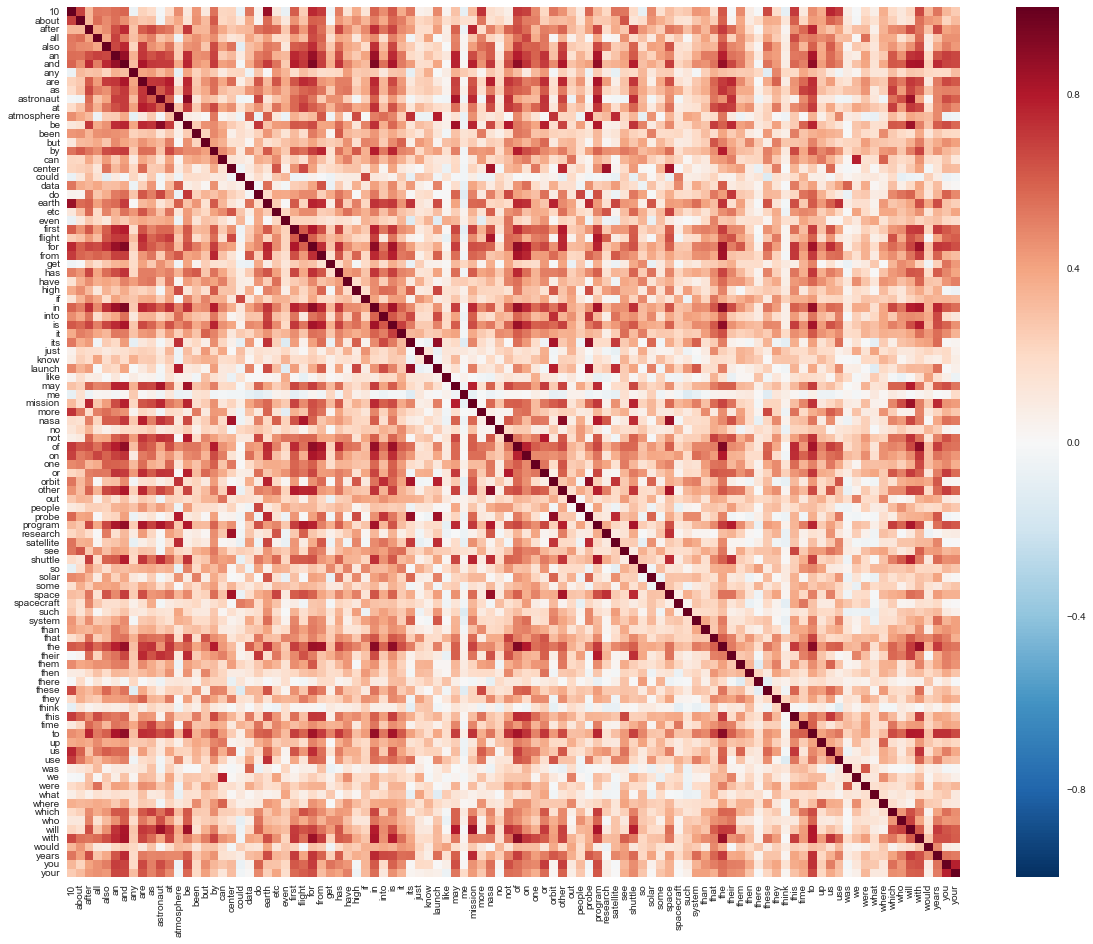

In [13]:
# CfU 5

plt.figure(figsize=(20,16))
sns.heatmap(answer.corr())

```
Instructor answer:

Almost **everything** co-occurs together! This seems like a really unhelpful dataset!
```

Certain words occur a huge amount but may not offer anything useful to us as modelers. We'll discuss removing these words shortly.

### `HashingVectorizer`

Sometimes we may have too many features or too many rows and run out of memory trying to process all of it. Sklearn provides a second option known as `HashingVectorizer` to avoid that.

- Benefit: Low memory footprint, allowing you to do more work
- Downside: No ability to determine which feature corresponds to what the original word is.

In most cases, we'll be using `CountVectorizer`, but `HashingVectorizer` can be a nice ace in the hole. 

#### How it Works

As you have seen we can set the `CountVectorizer` dictionary to have a fixed size, only keeping words of certain frequencies, however, we still have to compute a dictionary and hold the dictionary in memory. This could be a problem when we have a large corpus or in streaming applications where we don't know which words we will encounter in the future.

These problems can be solved using the `HashingVectorizer`, which converts a collection of text documents to a matrix of occurrences, calculated with the hashing trick. Each word is mapped to a feature with the use of a hash function that converts it to a hash. If we encounter that word again in the text, it will be converted to the same hash, allowing us to count word occurence without retaining a dictionary in memory. This is very convenient!

The main drawback of the this trick is that it's not possible to compute the inverse transform, and thus we lose information on what words the important features correspond to. The hash function employed is the signed 32-bit version of Murmurhash3.

We'll instantiate `HashingVectorizer` with the keyword argument `norm=None` to get back real value counts of words. The default is to normalize these values so as to prevent hashing collisions.

In [14]:
hvec = HashingVectorizer(norm=None)
hvec.fit(space_messages)
hvec.n_features

answer = pd.DataFrame(hvec.transform(space_messages).todense())
answer.sum().sort_values(ascending=False).head(10)

479532    461.0
174171    455.0
828689    302.0
144749    229.0
329790    177.0
832412    143.0
512176    122.0
170062    119.0
994433    103.0
408423    100.0
dtype: float64

### Stemming

Often, slightly different version of a word exist. For example: LinkedIn sees 6000+ variations of the title "Software Engineer" and 8000+ variations of the word "IBM".

It would be wrong to consider the words "MR." and "mr" to be different features, thus we need a technique to normalize words to a common root. This technique is called Stemming.

- Science, Scientist => Scien
- Swimming, Swimmer, Swim => Swim

We could define a Stemmer based on rules that we've decided on:

In [15]:
def stem(tokens):
    '''rules-based stemming of a bunch of tokens'''
    
    new_bag = []
    for token in tokens:
        # define rules here
        if token.endswith('s'):
            new_bag.append(token[:-1])
        elif token.endswith('er'):
            new_bag.append(token[:-2])
        elif token.endswith('tion'):
            new_bag.append(token[:-4])
        elif token.endswith('tist'):
            new_bag.append(token[:-4])
        elif token.endswith('ce'):
            new_bag.append(token[:-2])
        elif token.endswith('ing'):
            new_bag.append(token[:-2])
        else:
            new_bag.append(token)

    return new_bag

stem(['Science', 'Scientist'])

['Scien', 'Scien']

But it is often easier to make use of `nltk` to do so:

In [16]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
print(stemmer.stem('scientists'))
print(stemmer.stem('scientist'))

scientist
scientist


### Stop Words

Some words are very common and provide no information on the text content.

We should remove these stop words. Every language has different stop words and you can add your own words as well if it makes sense (for example, if you there was a domain word that was prevelant but ultimately uninformative, you should use your judgement to remove it).

`nltk` provides their own list of stop words:

In [17]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

We can also use `CountVectorizer` to remove common stopwords for us by setting the `stop_words` keyword argument to `english`

In [18]:
cv = CountVectorizer()
cv.fit(space_messages)
stopped_words = pd.DataFrame(cv.transform(space_messages).todense(),
                              columns=cv.get_feature_names())
print(stopped_words.sum().sort_values(ascending=False).head(10))

the     989
of      461
to      455
and     453
in      302
for     237
is      229
it      177
that    167
be      149
dtype: int64


In [19]:
cv = CountVectorizer(stop_words='english')
cv.fit(space_messages)
stopped_words = pd.DataFrame(cv.transform(space_messages).todense(),
                              columns=cv.get_feature_names())
print(stopped_words.sum().sort_values(ascending=False).head(10))

space         144
nasa           79
earth          53
shuttle        39
spacecraft     37
program        37
time           36
launch         36
mission        35
flight         34
dtype: int64


This dramatically changes the type of "common" words available.

### How to combine transformers

Working with text data requires a lot of preprocessing, as the effectiveness of your model can dramatically change based on how well you've processed your text data. 

In **most** cases, tweaking the settings of `CountVectorizer` will generally be ok. However, sometimes you may want to create a custom function to preprocess text for `CountVectorizer`.

Imagine that I wanted to do the following to my text:

- Remove punctuation and numbers
- Turn text lowercase
- Remove stop words
- Stem remaining words

We could imagine building a function to do that:

In [20]:
def cleaner(text):
    stemmer = PorterStemmer()
    stop = stopwords.words('english')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    text = text.lower().strip()
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

That would change our original spam message from:

In [21]:
print(spam)


Hello, I saw your contact information on LinkedIn. I have carefully read through your profile and you seem to have an outstanding personality. This is one major reason why I am in contact with you. My name is Mr. Valery Grayfer Chairman of the Board of Directors of PJSC "LUKOIL". I am 86 years old and I was diagnosed with cancer 2 years ago. I will be going in for an operation later this week. I decided to WILL/Donate the sum of 8,750,000.00 Euros(Eight Million Seven Hundred And Fifty Thousand Euros Only etc. etc.



to:

In [22]:
spam_cleaned = cleaner(spam)
print(spam_cleaned)

hello saw contact inform linkedin care read profil seem outstand person one major reason contact name mr valeri grayfer chairman board director pjsc lukoil year old diagnos cancer year ago go oper later week decid willdon sum euroseight million seven hundr fifti thousand euro etc etc


We can pass this function into `CountVectorizer` as a way to preprocess the text as a part of the fitting.

In [23]:
cv = CountVectorizer(preprocessor=cleaner)
cv.fit(space_messages)
custom_preprocess = pd.DataFrame(cv.transform(space_messages).todense(),
                              columns=cv.get_feature_names())
print(custom_preprocess.sum().sort_values(ascending=False).head(10))

space      128
nasa        71
orbit       68
would       66
use         60
one         54
launch      53
mission     51
program     44
earth       43
dtype: int64


### When to use a custom preprocessor callable

Starting off, I'd make use of what's built into `CountVectorizer` and see if that changes your outcome. However, if you've been working on a dataset for a longer amount of time (such as during your projects or your Capstone) you may want to start developing custom preprocessors that make more sense for the domain that you are in.

### Term frequency - Inverse document Frequency (tf-idf)

Tf-idf tells us which words are the most discriminating between documents. Words that occur a lot in one document but don't occur in many other documents tells you a lot more than a word that occurs frequently in all documents.

Take a look at the map below. These types of maps usually highlight the most **uniquely favorite food** of a state, not the actual favorite food (which in most cases is probably pizza).

Tf-idf, conceptually, does the same thing: it highlights what is common or typical in one or two cases and rare in all others. That's usually more interesting (and predictive) then words or items that are common everywhere.

![](./images/map-foods.png)

- Term frequency is the frequency of a certain term in a document
- Inverse document frequency is defined as the frequency of documents that contain that term over the whole corpus.

This technique reweights terms to strengthen those that are highly specific to a particular document, while suppressing terms that are common to most documents.

Formally, you'll usually see it like this:

$$ tf(t, d) = \frac{N_{term}}{N_{document}} $$

$$ idf(t, D) = log(\frac{N_{documents}}{N_{\text{documents that contain term t}}}) $$

We'll use sklearn's `TfidfVectorizer` to count vectorize and then transform that data using Tfidf:

In [24]:
tvec = TfidfVectorizer(stop_words='english')
tvec.fit([spam, ham])

df = pd.DataFrame(tvec.transform([spam, ham]).todense(),
                   columns=tvec.get_feature_names(),
                   index=['spam', 'ham'])
df.head()

,00,000,750,86,ago,application,assistance,attached,best,board,...,seven,site,smith,sum,thousand,time,valery,week,writing,years
spam,0.145067,0.145067,0.145067,0.145067,0.145067,0.000000,0.000000,0.000000,0.000000,0.145067,...,0.145067,0.000000,0.000000,0.145067,0.145067,0.000000,0.145067,0.145067,0.000000,0.290133
ham,0.000000,0.000000,0.000000,0.000000,0.000000,0.155195,0.155195,0.155195,0.155195,0.000000,...,0.000000,0.155195,0.155195,0.000000,0.000000,0.155195,0.000000,0.000000,0.155195,0.000000


In this case, we see that:

- words that don't show up a document have `0.0000` for values
- words that do show up in a document are weighted based on tf-idf -- as those scores increase in value, the those terms occur more uniquely in document _d_ than in other documents. 

### Check for Understanding 3 (15 minutes)

Let's practice some of these new techniques on `space_messages` that we established previously. As a reminder, these contain the first 100 messages in the space newsgroups dataset.

In [25]:
print(space_messages[0])


Any lunar satellite needs fuel to do regular orbit corrections, and when
its fuel runs out it will crash within months.  The orbits of the Apollo
motherships changed noticeably during lunar missions lasting only a few
days.  It is *possible* that there are stable orbits here and there --
the Moon's gravitational field is poorly mapped -- but we know of none.

Perturbations from Sun and Earth are relatively minor issues at low
altitudes.  The big problem is that the Moon's own gravitational field
is quite lumpy due to the irregular distribution of mass within the Moon.


Individually, please try and tackle the following questions. You may find it helpful to use some of the code you wrote for the first Check for Understanding.

1. Use the default `CountVectorizer()` to create a DataFrame and answer the following questions (note, we also did this same prompt in the first CfU -- this is to remind us of where we're starting from):
    - How large is your DataFrame?
    - What are the top 10 occuring words?
2. Use `CountVectorizer()` and remove stop words with the `stop_words` keyword argument. 
    - How large is your DataFrame?
    - What are the top 10 occuring words?
3. Use `TfIdfVectorizer()` and remove stop words with the `stop_words` keyword argument.
    - How large is your DataFrame?
    - Interpret the values that are in the DataFrame. What do they mean?
4. We've tried a bunch of different ways to transform the same text data into numbers across this check for understanding and the previous one. Pick two methods and compare and contrast them. What type of words are included in each DataFrame? What types of words are removed or reduced in impact?

When you're finished working individually, share your work with a partner. Did you come to the same conclusions? What happens if you try this with new data?

In [26]:
# CfU

cv = CountVectorizer()

answer = answer_df_questions(space_messages, cv)

Size: (100, 4631)
Top 10 Words:
 the     989
of      461
to      455
and     453
in      302
for     237
is      229
it      177
that    167
be      149
dtype: int64


In [27]:
# CfU 2

cv = CountVectorizer(stop_words='english')

answer = answer_df_questions(space_messages, cv)

Size: (100, 4381)
Top 10 Words:
 space         144
nasa           79
earth          53
shuttle        39
spacecraft     37
program        37
time           36
launch         36
mission        35
flight         34
dtype: int64


In [28]:
# CfU 3

tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(space_messages)

tfidf_df = pd.DataFrame(tfidf.transform(space_messages).todense(),
                   columns=tfidf.get_feature_names())

tfidf_df.head()

,00,000,0000,00000,00041032,0004246,0004422,00044513,0022,0034,...,ysc,yscvax,yuppie,z3,zenit,zeta,zhao,zillion,zipping,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


```
Instructor answer:

Many more of our values will be smaller here. Words that occur a large amount in one or two documents and not often elsewhere will now have a higher value, highlighting their uniqueness.
```

```
Instructor answer for CfU 4:

Rather than a compare and contrast, let's run through a few options and what they do:

- min_df / max_df: limits what words are included based on the frequency that they occur in the corpus
- stop words: removes words that occur frequently but don't impart useful meaning
- stemming: makes words that relate conceptually to the same root (such as science and scientist) into the same word (so that the concept is highlighted more than the grammatical form)
- tf-idf: transforms the data so that words that occur more frequently in one document when compared to all other documents have higher values
```

### How to apply NLP

Typically, we'll use NLP in the feature engineering stage to help us create new features for our data, which we'll then use in either structured or unstructured modeling techniques. What follows is an example of how we might apply this process. We'll first do this in an ad-hoc fashion, then refactor our code for a more production-ready format.

#### Getting Data

Let's use a truncated dataset about the news. This is a set of 8000 randomly selected news articles with an indicator as to whether the news article is discussing economic news or not. 

In [29]:
econ = pd.read_csv('datasets/economic_news.csv', 
                   usecols=[7, 11, 14])
econ.head()

,relevance,headline,text
0,yes,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...
1,no,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...
2,no,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...
3,no,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...
4,yes,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...


In [30]:
print(econ.iloc[0, 2])

NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday's auction plummeted more than a fifth of a percentage poin

Let's dummify the `relevance` column and strip out `</br>` from our text:

In [31]:
econ['relevance'] = econ['relevance'].apply(lambda x: 1 if x == 'yes' else 0)
econ['text'] = econ['text'].apply(lambda x: x.replace('</br>', ''))
econ['headline'] = econ['headline'].apply(lambda x: x.replace('</br>', ''))

In [32]:
for x in range(3):
    print(econ.iloc[0,x])

1
Yields on CDs Fell in the Latest Week
NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.Yields on three-month and six-month Treasury bills sold at Monday's auction plummeted more than a fifth of a percentage poin

And let's split into a training set and a test set, using the `text` of the document.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(econ['text'].values, 
                                                   econ['relevance'].values,
                                                   test_size=0.33,
                                                   random_state=2017)

#### Transforming data using `CountVectorizer`

We'll use `CountVectorizer` in its default form to prepare a dataframe for modeling. Note that I'm going to leave this in its sparse form, because it typically won't matter for the next step.

In [34]:
cv = CountVectorizer()
cv.fit(X_train)
X = cv.transform(X_train)
print(X.shape)

(5360, 38310)


#### Dimensionality Reduction with PCA

Typically, those 38,000+ columns are not individually informative. Reducing them in dimensionality using PCA can be very helpful. We'll be using a variant of PCA known as [`TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) -- it does more or less the same thing as PCA but in a slightly different fashion. It's best used with sparse matrices like these. 

**Note**: `TruncatedSVD` works on the actual matrix itself, _not_ the covariance matrix like PCA. This means that the maximum number of components you can make is limited to the smaller of your rows or columns. In this case, even though we have a large number of columns, we only have around 5,000 rows, meaning that the largest number of components `TruncatedSVD` will be able to make is that number.

First, we'll pick a high number of components and graph the explained variance ratio to see if there's a useful cutoff point:

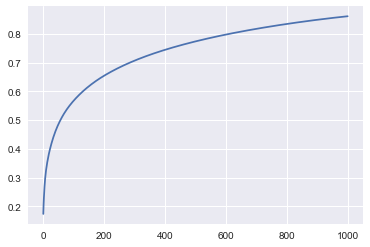

In [35]:
tsvd = TruncatedSVD(n_components=1000)
tsvd.fit(X)
plt.plot(range(1000), tsvd.explained_variance_ratio_.cumsum())

This graph would suggest that somewhere north of 100 components might be pretty good (it is where the rate of change begins to flatten out). I'm going to stick with a smaller number (10) for the time being for modeling speed. This will be one of the things we tweak in our Check for Understanding later.

In [36]:
tsvd = TruncatedSVD(n_components=10)
tsvd.fit(X)
X_tsvd = tsvd.transform(X)

#### Predicting with `RandomForestClassifier`

At this point, we can move forward with modeling on our new sparse matrix of data:

In [37]:
rfc = RandomForestClassifier()
rfc.fit(X_tsvd, y_train)
print(rfc.score(X_tsvd, y_train))
print(confusion_matrix(y_train, rfc.predict(X_tsvd)))
print(classification_report(y_train, rfc.predict(X_tsvd)))

0.980410447761
[[4425    1]
 [ 104  830]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      4426
          1       1.00      0.89      0.94       934

avg / total       0.98      0.98      0.98      5360



This is an exceptionally good model with high accuracy, though we do misclassify about 12% of our class 1 (economic) news as non-economic news. However, we should check to make sure that it works equally well on our test data. As before, we'll make sure that we are applying the already fit transformation to our test data, not refitting.

In [38]:
X_test_cv = cv.transform(X_test)
X_test_svd = tsvd.transform(X_test_cv)
print(rfc.score(X_test_svd, y_test))
print(confusion_matrix(y_test, rfc.predict(X_test_svd)))
print(classification_report(y_test, rfc.predict(X_test_svd)))

0.805681818182
[[2094   60]
 [ 453   33]]
             precision    recall  f1-score   support

          0       0.82      0.97      0.89      2154
          1       0.35      0.07      0.11       486

avg / total       0.74      0.81      0.75      2640



We do a little worse here, as expected -- we almost completely misclassify all of our economic news as non-economic news. However, this process does identify our general process for modeling with text data:

1. Use the NLP techniques that we've identified to clean and prepare the data
2. Consider using a dimensionality reduction technique like `TruncatedSVD`
3. Use the prepared data with machine learning techniques that we've already seen before to predict things.

### Check for Understanding 3 (20 minutes)

This is an open ended check for understanding. Your goal at the end of 20 minutes is to have a better model with this same data that maximizes the class 1 recall of our model on the test data:

> Our current model at this point correctly predicts 24 of 486 economic articles correctly -- we want to increase the predictive power of our model for that test case!

How you do so is up to you (exploring how the data is transformed is highly encouraged). Some options:

- Use stop words and other arguments in `CountVectorizer` to change which features are engineered
- Make use of `TfidfVectorizer` to highlight more unique words
- Modify your the number of components created in `TruncatedSVD`
- Try a different modeling technique
- Use `GridSearchCV` to optimize hyperparameters

```
Instructor Answer:

This is *one* of many possible answers. Your goal is to explore and familiarize yourself with the modeling process. Do not assume this code is the best (or close to the best) solution.

I'm going to remove stopwords and use TfIdfVectorizer instead of CountVectorizer. I'll choose a larger number of components here and Grid Search over some hyperparameters. I'll also switch my modeling technique out of RandomForestClassifier to a simpler LogisticRegression -- don't be afraid to try different techniques
```

In [39]:
vec = CountVectorizer(stop_words='english')
vec.fit(X_train)
X_tfidf = vec.transform(X_train)
X_tfidf

<5360x38009 sparse matrix of type '<class 'numpy.int64'>'
	with 537843 stored elements in Compressed Sparse Row format>

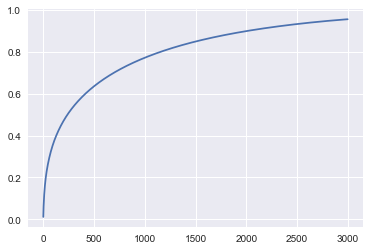

In [40]:
tsvd_example = TruncatedSVD(n_components=3000)
tsvd_example.fit(X_tfidf)
plt.plot(range(3000), tsvd_example.explained_variance_ratio_.cumsum())

In [41]:
X_tfidf_tsvd = tsvd_example.transform(X_tfidf)

params_grid = {
    'C': [0.01, 0.10, 1.0, 10.0],
    'penalty': ['l1', 'l2']
}

gs = GridSearchCV(LogisticRegression(),
                 param_grid=params_grid,
                 scoring='recall', #pushes estimator to look at the recall score
                 n_jobs=-1,
                 verbose=2)

gs.fit(X_tfidf_tsvd, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=0.01, penalty=l1 ..............................................
[CV] C=0.01, penalty=l1 ..............................................
[CV] C=0.01, penalty=l1 ..............................................
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   3.7s
[CV] ............................... C=0.01, penalty=l1, total=   4.1s
[CV] C=0.01, penalty=l2 ..............................................
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   4.3s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ............................... C=0.01, penalty=l2, total=   4.6s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total=   3.1s
[CV] C=0.1, penal

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   57.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1.0, 10.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=2)

In [42]:
print(gs.best_score_)
print(gs.best_params_)
best_estimator = gs.best_estimator_

0.325444983221
{'C': 10.0, 'penalty': 'l1'}


In [44]:
X_test_cv = vec.transform(X_test)
X_test_svd = tsvd_example.transform(X_test_cv)
print(best_estimator.score(X_test_svd, y_test))
print(confusion_matrix(y_test, best_estimator.predict(X_test_svd)))
print(classification_report(y_test, best_estimator.predict(X_test_svd)))

0.767424242424
[[1890  264]
 [ 350  136]]
             precision    recall  f1-score   support

          0       0.84      0.88      0.86      2154
          1       0.34      0.28      0.31       486

avg / total       0.75      0.77      0.76      2640



### Revisiting Pipelines

We may also want to create a `Pipeline` object to reproducibly and reliably transform and predict data with one step versus many. We'll refactor our code here to take advantage of that and end with a check for understanding where you can practice the same. 

The first step is to break down our current model into a set of sequential steps. From my original example using the economic news dataset, my steps were:

1. Apply `CountVectorizer` to `X` (matrix of article text)
2. Apply `TruncatedSVD` with 10 components to the count vectorized data
3. Predict using `RandomForestClassifier`

These steps are _sequential_ and can feed one directly into the other. We do not need to include a feature union here.

In [45]:
pipeline = make_pipeline(
    CountVectorizer(),
    TruncatedSVD(n_components=10),
    RandomForestClassifier())

If we had more hyperparameters or different steps, we could change what is inside that pipeline to account for that. 

Next, let's fit this to our training data:

In [46]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

Then we'll score it and run the predictions from the training set.

In [47]:
print(pipeline.score(X_train, y_train))
predictions = pipeline.predict(X_train)
print(confusion_matrix(y_train, predictions))
print(classification_report(y_train, predictions))

0.978171641791
[[4425    1]
 [ 116  818]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.99      4426
          1       1.00      0.88      0.93       934

avg / total       0.98      0.98      0.98      5360



And finally, we'll score and predict with our test set. We do not need to refit this to the test set!

In [48]:
print(pipeline.score(X_test, y_test))
predictions = pipeline.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.805681818182
[[2108   46]
 [ 467   19]]
             precision    recall  f1-score   support

          0       0.82      0.98      0.89      2154
          1       0.29      0.04      0.07       486

avg / total       0.72      0.81      0.74      2640



### Check For Understanding 4 (15 Minutes)

Pair up and do the following:

1. Using the model you created in the last Check for Understanding, diagram out the steps involved in going from the training data to a fitted model with your partner. Highlight what steps can happen sequentially and which must happen in parallel (typically parallel steps would happen during the feature engineering stage)

2. Pick a model and refactor the code to use a `Pipeline` instead of its current version. Write this code on the machine that doesn't have the original model on it. This is to help you think about what your code is *doing* versus how you've *written* it

3. If you have time, replicate the process for the other model. 

If you used a grid search, feel free to set the best parameters manually (such as `RandomForestClassifier(n_estimators=100)`).

```
Instructor answer:

My refactored code for Check for Understanding 3 is below
```

In [49]:
example_pipe = make_pipeline(
    CountVectorizer(stop_words='english'),
    TruncatedSVD(n_components=3000),
    LogisticRegression(C=10.0, penalty='l1')
    )

example_pipe.fit(X_train, y_train)

## Testing on the test set

print(example_pipe.score(X_test, y_test))
predictions = example_pipe.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.768560606061
[[1886  268]
 [ 343  143]]
             precision    recall  f1-score   support

          0       0.85      0.88      0.86      2154
          1       0.35      0.29      0.32       486

avg / total       0.75      0.77      0.76      2640

